In [1]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
import networkx as nx
import os, sys
from itertools import product
from matplotlib.animation import FuncAnimation
import math

In [2]:
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(20,8)})
%matplotlib nbagg
#%matplotlib qt



#global function that calculates the weight of the edge, args: the 2 nodes (agent class objects)
def Edge_Weight(node1,node2, b, alpha):
        try:
             weight = 1+math.exp(alpha*((node1.m-node2.m)-b))
        except OverflowError:
             weight = float('inf')
        return 1/weight
                

In [3]:
class MoneyAgent(Agent):
    
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.m = self.model.T
        self.lamda = round(random.uniform(0.1,1),1)
        while (self.lamda == 1):
            self.lamda = round(random.uniform(0.1,1),1)
        self.model.agents.append(self)
        
    def neighbors(self):
        neighbors_nodes = list(nx.all_neighbors(self.model.G,self.unique_id))
        neighbors = []
        for node in neighbors_nodes:
            for agent in self.model.agents:
                if(agent.unique_id == node):
                    neighbors.append(agent)
        return neighbors
            
    def give_money(self):
        b = self.model.b
        alpha = self.model.alpha
        neighbors = self.neighbors()
        epsilon = random.random()
        if len(neighbors) > 1 :
            other = self.random.choice(neighbors)
            while(other.unique_id == self.unique_id):
                other = self.random.choice(neighbors)  
            w = self.model.G[self.unique_id][other.unique_id]['weight'] 
            #print(w)
            if(w >= random.random()): 
                xi = self.m
                xj = other.m
                delta_m = (1-self.lamda)*(xi - epsilon*(xi + xj))
                xi_new = xi - delta_m
                xj_new = xj + delta_m
                other.m = xj_new
                self.m = xi_new
                for neighbor in neighbors:
                    self.model.G[self.unique_id][neighbor.unique_id]['weight'] = Edge_Weight(self,neighbor,b, alpha)
                other_neighbors = other.neighbors()
                for neighbor in other_neighbors:
                    if(neighbor.unique_id != other.unique_id):
                        #print("Other: {}  Neighbor: {}".format(other.unique_id,neighbor.unique_id))
                        self.model.G[other.unique_id][neighbor.unique_id]['weight'] = Edge_Weight(other,neighbor,b, alpha)
                
    def Local_Attachment(self):
        b =  self.model.b
        alpha = self.model.alpha
        node1 = random.choice(self.model.nodes)
        node2 = random.choice(self.model.nodes)
        global node1_a, node2_a
        while(self.model.G.has_edge(node1,node2)==True):
            node2 = random.choice(self.model.nodes)
            node1 = random.choice(self.model.nodes)
        for agent in self.model.agents:
            if(agent.unique_id == node1):
                node1_a = agent
            if(agent.unique_id == node2):
                node2_a = agent
        self.model.G.add_edge(node1,node2,weight = Edge_Weight(node1_a,node2_a, b, alpha))
        
    
    def Link_Deletion(self):
        node1 = random.choice(self.model.nodes)
        node2 = random.choice(self.model.nodes)
        while(self.model.G.has_edge(node1,node2)==False):
            node1 = random.choice(self.model.nodes)
            node2 = random.choice(self.model.nodes)
        self.model.G.remove_edge(node1,node2)
        
                 
    def step(self):
        if self.m > 0:
            self.give_money()
        self.Local_Attachment()
        self.Link_Deletion()

In [10]:
class BoltzmannWealthModelNetwork(Model):
    """A model with some number of agents."""

    def __init__(self,b, alpha, fig, ax,steps, T=100,N=500): #N- number of agents

        self.N = N
        self.T = T
        self.b =b
        self.alpha = alpha
        self.agents = []
        self.fig = fig
        self.ax = ax
        self.steps = steps
        self.G = nx.barabasi_albert_graph(n=N, m = 1)
        nx.set_edge_attributes(self.G, 1, 'weight') #setting all initial edges with a weight of 1
        self.nodes = np.linspace(1,N,N, dtype = 'int') #to keep track of the N nodes  
        self.points = []
        self.p = []
        self.large = T
        self.small = 0
        
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(model_reporters = {'beta': 'b', 'alpha': 'alpha'},agent_reporters={"mi":'m','lamda':'lamda' })
        
        for i, node in enumerate(self.G.nodes()):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
           
        self.running = True
        self.datacollector.collect(self)
        
    def Global_Attachment(self):
        #print("Global Attachment no: {}".format(self.count))
        node1 = random.choice(self.nodes)
        node2 = random.choice(self.nodes)
        self.large = max(agent.m for agent in self.agents)
        self.small = min(agent.m for agent in self.agents)
        #print(self.large, self.small)
        global node1_a, node2_a
        while(self.G.has_edge(node1,node2)==True):
            node2 = random.choice(self.nodes)
            node1 = random.choice(self.nodes)
        #adding the edge node1-node2
        for agent in self.agents:
            if(agent.unique_id == node1):
                node1_a = agent
            if(agent.unique_id == node2):
                node2_a = agent
        #print(node2_a.unique_id)
        self.G.add_edge(node1,node2,weight = Edge_Weight(node1_a, node2_a, self.b, self.alpha))
    
    def init(self):
        pass

        
    def update(self, i):
        #print("This is getting called {}".format(i))
        for k in self.p:
            k.remove()
        self.p = []
        for j in self.points:
            j.remove()
        self.points = []
        #self.ax.clear()
        self.ax.set_title("Money with different agents at time step : {}".format(i+1))
        self.p.append(self.ax.axhline(y = self.large, ls = '--', color = 'red', label = "Maximum money"))
        self.p.append(self.ax.axhline(y = self.small, ls = '--', color = 'steelblue', label ="Minimum money"))
        for n, agent in zip(self.nodes, self.agents):
            if(n!=30):
                self.points.append(self.ax.scatter(n, agent.m, color = 'orange'))
            else:
                self.ax.scatter(n, agent.m, color = 'black')
            #print(n, agent.m)
        self.ax.legend(loc = 'upper right')
        self.run_model()
        
    
    def animate(self):
        self.anim = FuncAnimation(self.fig, self.update,frames = self.steps,init_func = self.init, interval=1000, save_count = self.steps, repeat = False)
        plt.show()
        self.anim.save('animation.mp4', fps=1)

    def step(self):
        self.schedule.step()
        # collect data
        self.datacollector.collect(self)

    def run_model(self):
        self.step()
        #print("hello")
        self.Global_Attachment()
        #here, find mean and variance and save it as model parameters

<IPython.core.display.Javascript object>


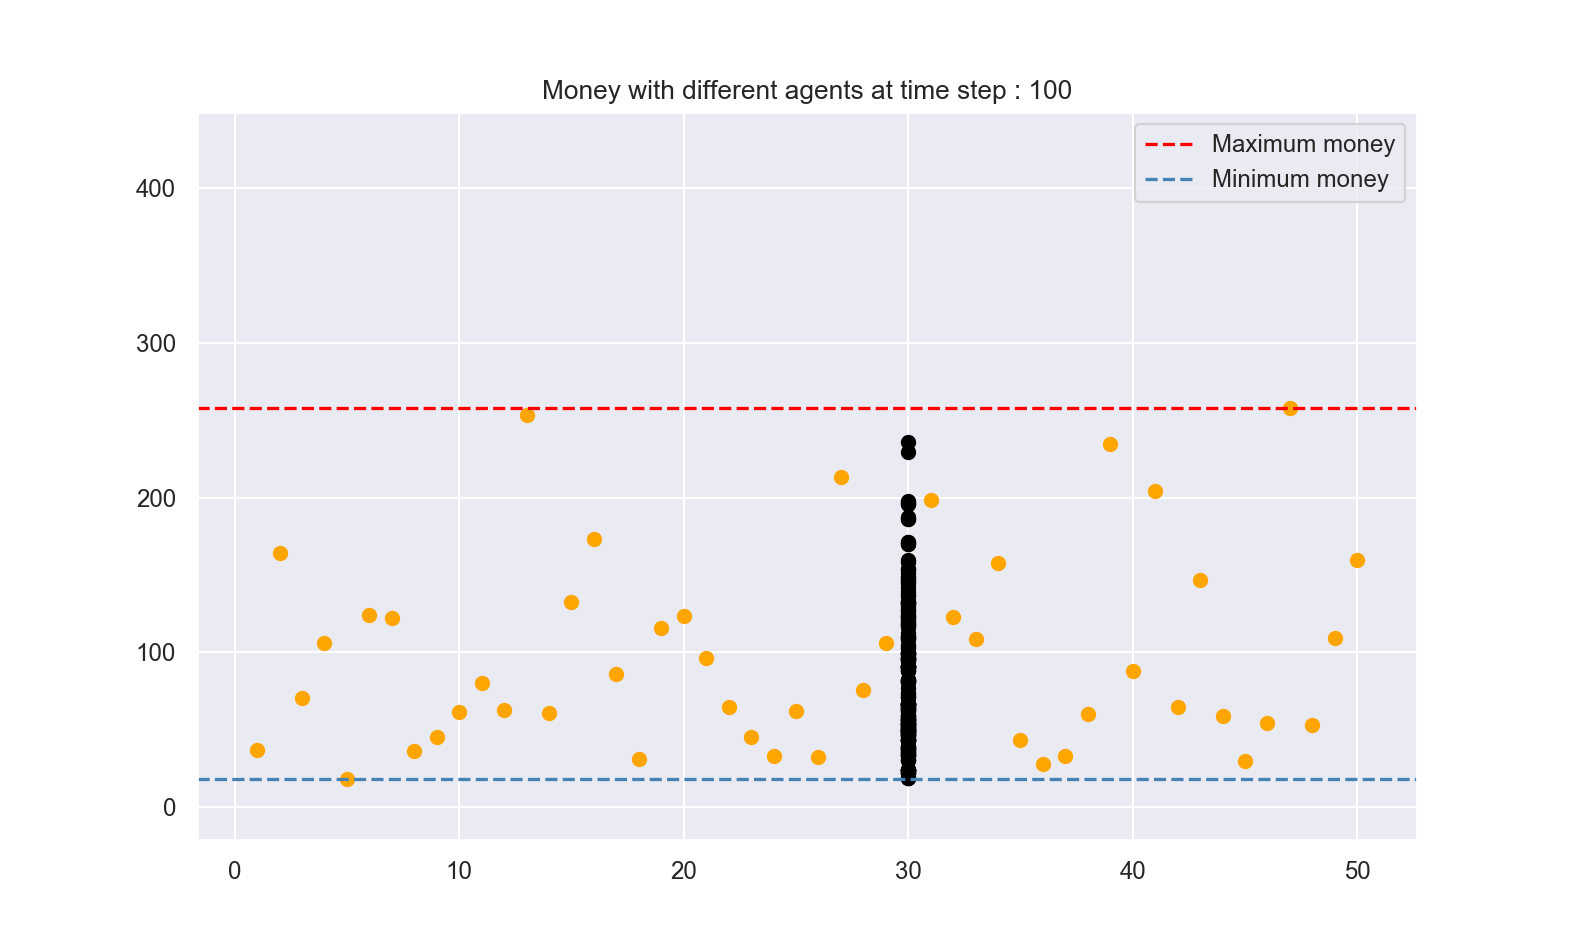

This is getting called 0
This is getting called 1
This is getting called 2
This is getting called 3
This is getting called 4
This is getting called 5
This is getting called 6
This is getting called 7
This is getting called 8
This is getting called 9
This is getting called 10
This is getting called 11
This is getting called 12
This is getting called 13
This is getting called 14
This is getting called 15
This is getting called 16
This is getting called 17
This is getting called 18
This is getting called 19
This is getting called 20
This is getting called 21
This is getting called 22
This is getting called 23
This is getting called 24
This is getting called 25
This is getting called 26
This is getting called 27
This is getting called 28
This is getting called 29
This is getting called 30
This is getting called 31
This is getting called 32
This is getting called 33
This is getting called 34
This is getting called 35
This is getting called 36
This is getting called 37
This is getting called

In [11]:
N = 50
T = 100
steps = 100
b = 35.98
alpha = 0.6933
fig, ax = plt.subplots(figsize = (10,6))
model = BoltzmannWealthModelNetwork(b, alpha,fig, ax,steps, T,N)
node2_a = MoneyAgent('dummy',model)
node1_a = MoneyAgent('dummy', model)
model.animate()
model_df = model.datacollector.get_model_vars_dataframe()
agent_df = model.datacollector.get_agent_vars_dataframe()
agent_df.reset_index(level=1, inplace = True)
agent_df['mt'] = agent_df.mi/T